In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft
import pylab as pl
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
plt.rcParams["figure.figsize"] = (16,8) # 10, 5

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# data_puzzle.dat:
# https://drive.google.com/open?id=1emQxtwN4DXTgeup-DUufjAJ1QZmyuTXh
filename = 'data_puzzle.dat'
id = '1emQxtwN4DXTgeup-DUufjAJ1QZmyuTXh'
drive.CreateFile({'id': id}).GetContentFile(filename)
data = pd.read_csv(filename, header=None, sep=',', error_bad_lines=False)

In [ ]:
data.head()

,0
0,12.0
1,12.0
2,3.0
3,0.0
4,0.0


In [ ]:
series = pd.Series(data[0])

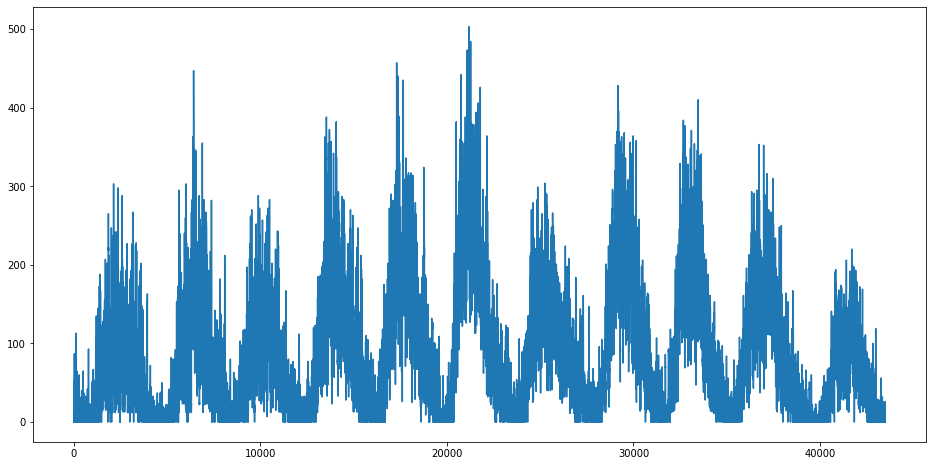

In [ ]:
series.plot()

# <center> Logarithmic returns </center>

In [ ]:
# obliczanie logarytmicznej stopy zwrotu
returns = np.log(series / series.shift(1))

In [ ]:
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna()
print(returns)

1        0.000000
2       -1.386294
12       0.860201
13      -0.144581
14      -0.510826
           ...   
43489    0.122602
43490   -0.313658
43491   -0.171850
43492   -0.207639
43493   -0.167054
Name: 0, Length: 36653, dtype: float64


In [ ]:
def plot_and_hist(data: pd.Series) -> None:
  data.plot()
  labels= ["Logarithmic return"]
  plt.legend(labels)
  plt.xlabel("time")
  plt.ylabel("logarithmic return value")
  # plt.xscale("log")
  # plt.yscale("log")
  plt.show()
  data.hist(bins=100)
  labels= ["Histogram of returns before transformation"]
  plt.legend(labels)
  plt.xlabel("return values")
  plt.ylabel("frequency")
  plt.show()
  abs(data).hist(bins=100)
  labels= ["Histogram of returns after transformation (with absolute value)"]
  plt.legend(labels)
  plt.xlabel("return values")
  plt.ylabel("frequency")
  plt.show()

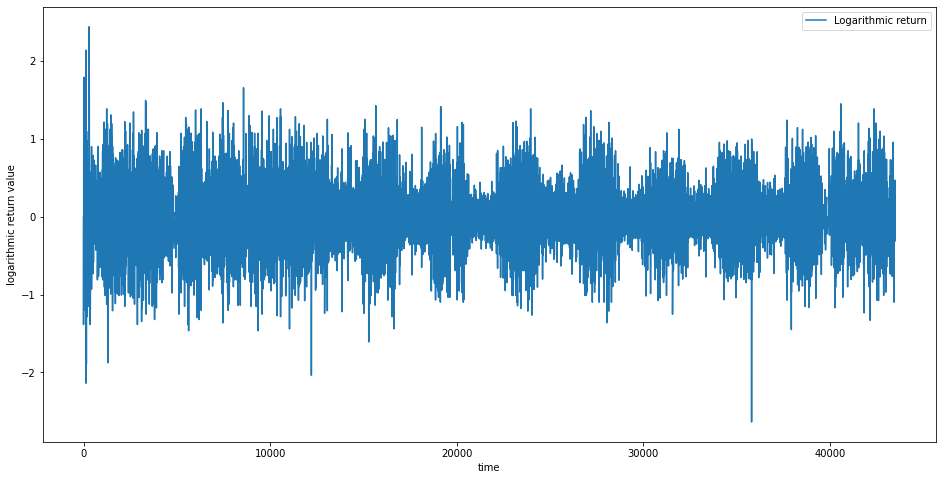

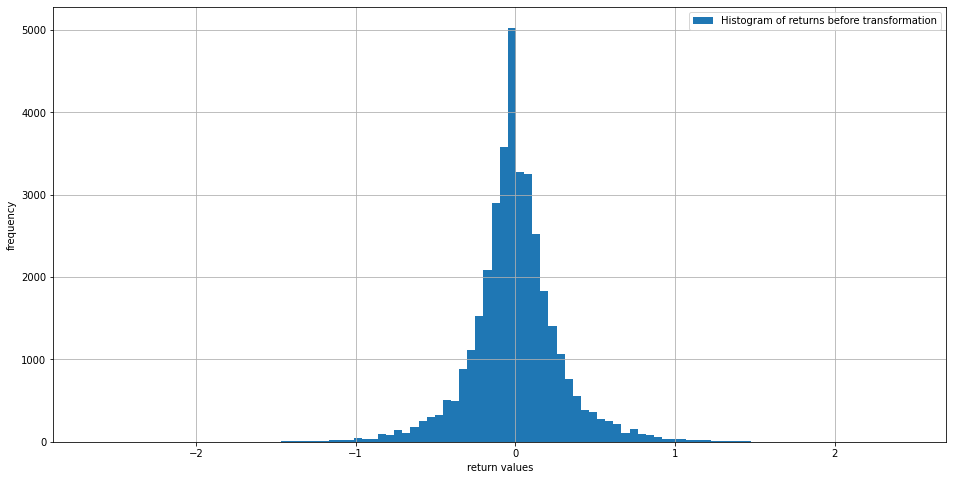

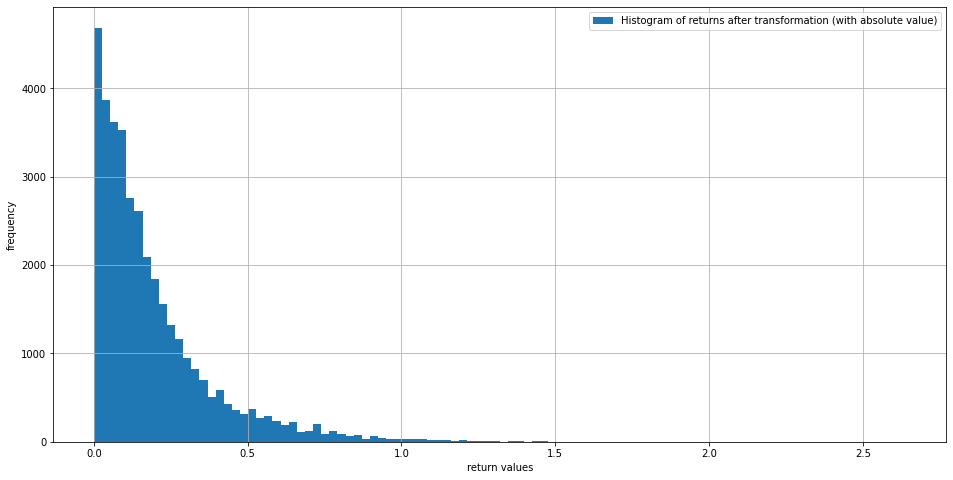

In [ ]:
plot_and_hist(returns)

# <center> Standarized logarithmic returns </center>

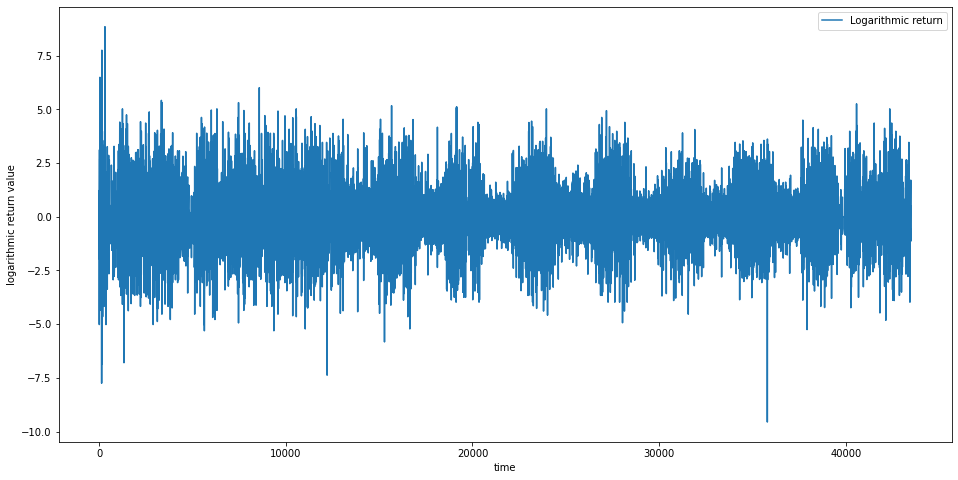

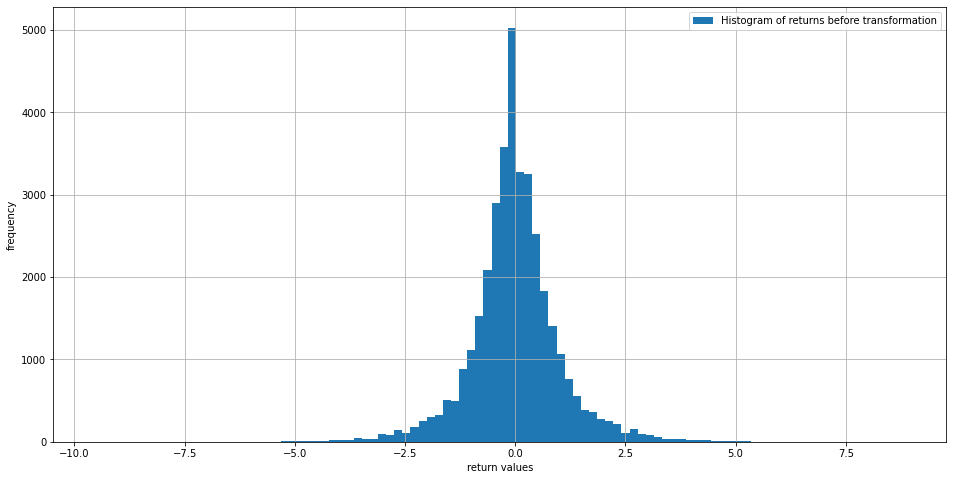

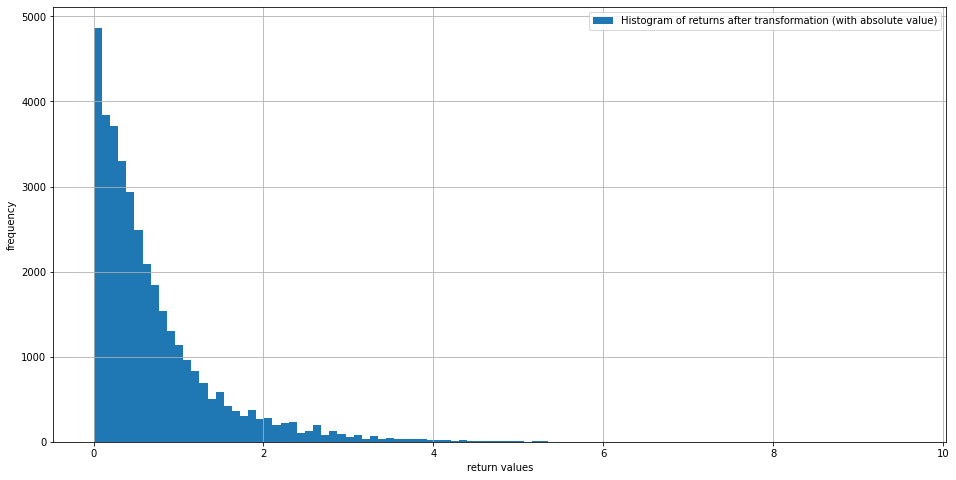

In [ ]:
standarized_returns = (returns - np.mean(returns)) / np.std(returns)
plot_and_hist(standarized_returns)

# <center> Cumulative distribution function (cdf) </center>

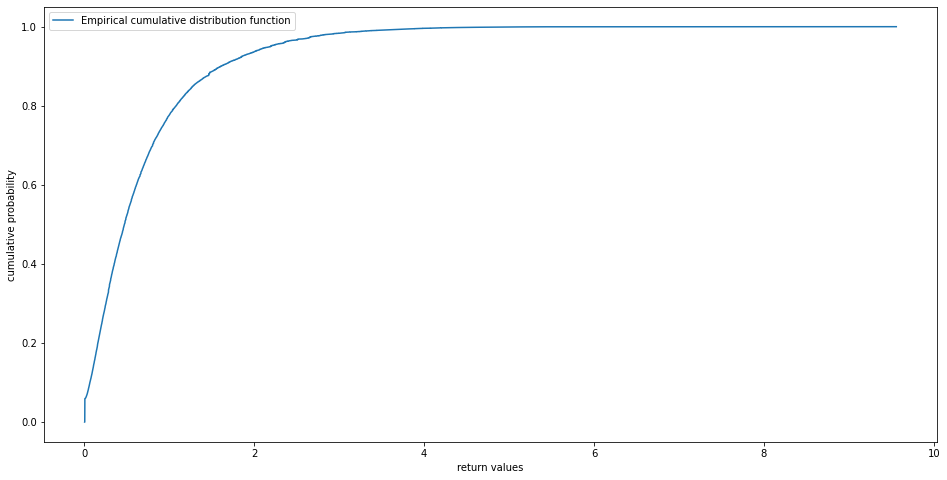

In [ ]:
# ecdf = ECDF(standarized_returns)
ecdf = ECDF(abs(standarized_returns))
plt.plot(ecdf.x, ecdf.y)
labels= ["Empirical cumulative distribution function"]
plt.legend(labels)
plt.xlabel("return values")
plt.ylabel("cumulative probability")
plt.show()

Mając dystrybuantę (cdf) nie musimy całkować funkcji gęstości (pdf) (lub sumować wartości tej funkcji w przypadku dyskretnym - pmf) za każdym razem, gdy chcemy policzyć prawdopodobieństwo. Przykładowo, jeżeli $X=(X_k)_{k=1}^{n}$ jest naszym szeregiem czasowym oraz $f_X$ jest gęstością prawdopodobieństwa zmiennej $X_t$ (wartość w danym punkcie czasowym), to możemy obliczyć prawdopodobieństwo przyjęcia przez zmienną $X_t$ wartości mniejszej niż $x$:
$$F_X(x)=P(X_t \leq x) = \int_{-\infty}^xf_X(x)dx$$
w przypadku ciągłym lub
$$F_X(x)=P(X_t \leq x) = \sum_{k=1}^nP(X_t=x_k) = \sum_{k=1}^np_X(x_k)$$
w przypadku dyskretnym, gdzie $p_X$ jest funkcją masy prawdopodobieństwa, oraz $n=\max\{{i\in \mathbb{N}}: x_i\leq x\}$. Dodatkowo, co jest chyba bardziej istotne, **dzięki cdf możemy też obliczać p-value dla różnych testów statystycznych**.

Dla przykładu sprawdzimy jakie jest prawdopodobieństwo tego, że w pewnym czasie $t$ wartość stopy zwrotu będzie mniejsza niż $2$. Ponieważ nasza dystrybuanta jest w istocie dyskretna, może się zdarzyć, że nie znamy wartości dystrybuanty dla argumentu równego dokładnie $2$. Dlatego w tablicy ecdf.x, która zawiera wartości stopy zwrotu (argumenty) znajdziemy pierwszy indeks, dla którego wartość jest większa lub równa $2$. a następnie sprawdzimy jaka jest wartość dystrybuanty w tym punkcie. 

In [ ]:
result = np.where(ecdf.x > 2)
first_index_of_value = result[0][0]
print("P(X_t <= {}) = {}".format(ecdf.x[first_index_of_value], ecdf.y[first_index_of_value]))

P(X_t <= 2.0001845182612668) = 0.9366218317736611


# <center> Autocorrelation function </center>

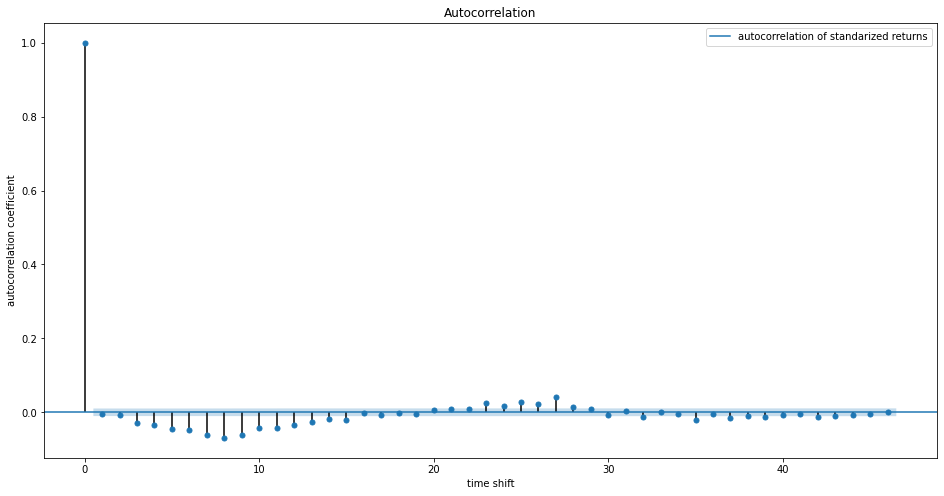

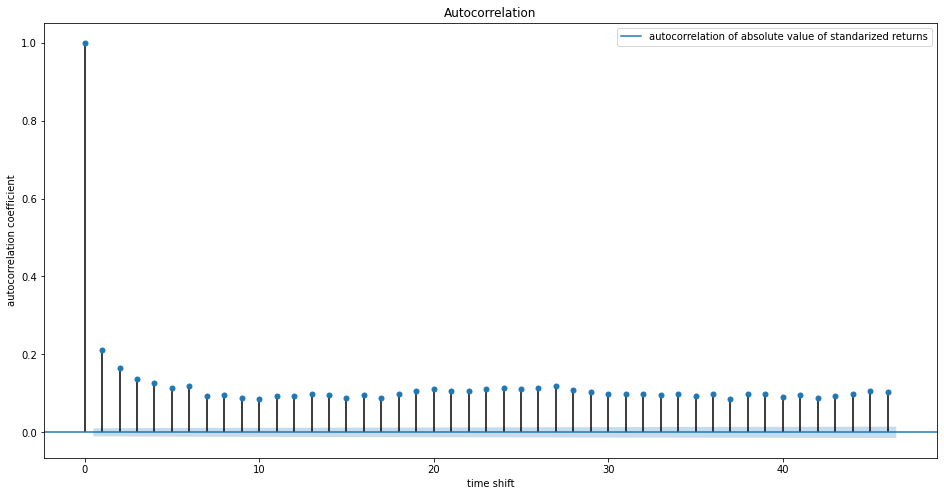

In [ ]:
ax = plot_acf(standarized_returns)
labels= ["autocorrelation of standarized returns"]
plt.legend(labels)
plt.xlabel("time shift")
plt.ylabel("autocorrelation coefficient")
plt.show()
plot_acf(abs(standarized_returns))
labels= ["autocorrelation of absolute value of standarized returns"]
plt.legend(labels)
plt.xlabel("time shift")
plt.ylabel("autocorrelation coefficient")
plt.show()

Dla ustandaryzowanego szeregu returnów autokorelacja jest raczej zaniedbywalna, natomiast dla szeregu modułów returnów jest ona trochę większa - około 15%-20% i nie zależy aż tak od przesunięcia czasowego. Zatem, przesuwając nasz szereg, jedna na pięć lub sześć predykcji powinna się sprawdzić. Przedziały ufności są pokazywane jako stożki (tutaj je słabo widać, ale są to jasno-niebieskie pola zaznaczone wokół osi odciętych). Domyślnie przedziały ustawione są na 95%, sugerując, że wszystkie wartości autokorelacji poza tym stożkiem są bardzo prawdopodobnie korelacją, a nie statystycznym przypadkiem.

# <center> Fourier Transform</center>

In [ ]:
random_series = np.random.normal(loc=0, scale=1, size=len(data))
returns_f1 = fft(np.array(random_series))
# transformacja naszej ustandaryzowanej logarytmicznej stopy zwrotu
returns_f2 = fft(np.array(standarized_returns))

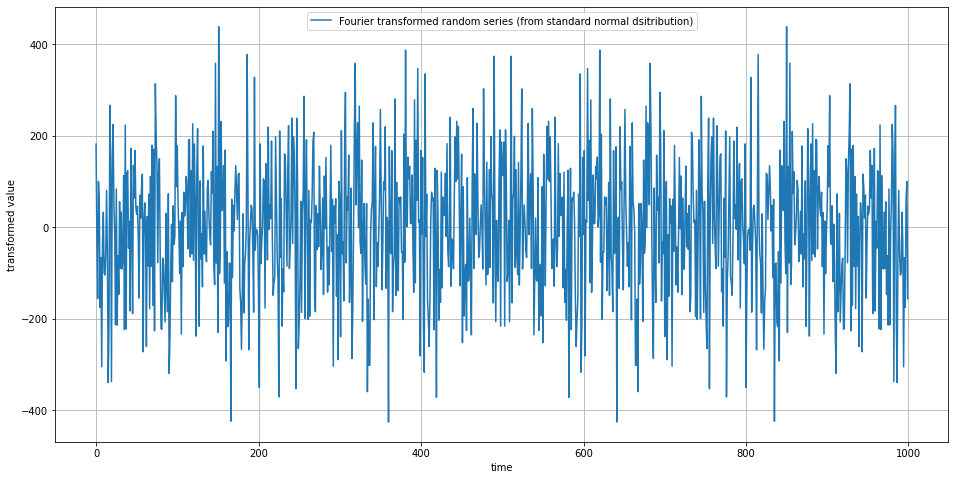

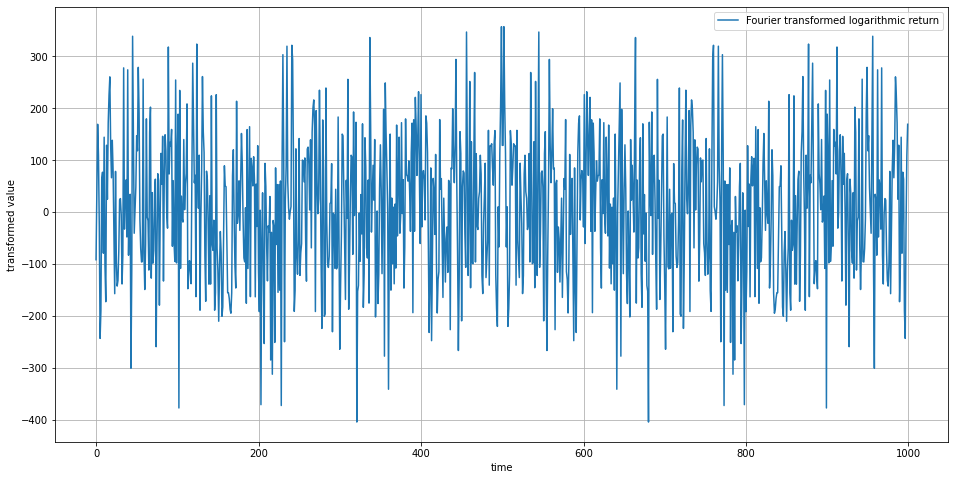

In [ ]:
# okno o długości 1000 ustawione na środku danych
plt.plot(returns_f1[int(len(returns_f1)/2)-500:int(len(returns_f1)/2)+500])
plt.grid()
labels= ["Fourier transformed random series (from standard normal dsitribution)"]
plt.legend(labels)
plt.xlabel("time")
plt.ylabel("transformed value")
plt.show()
plt.plot(returns_f2[int(len(returns_f2)/2)-500:int(len(returns_f2)/2)+500])
plt.grid()
labels= ["Fourier transformed logarithmic return"]
plt.legend(labels)
plt.xlabel("time")
plt.ylabel("transformed value")
plt.show()

In [ ]:
from numpy import fft
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 500                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

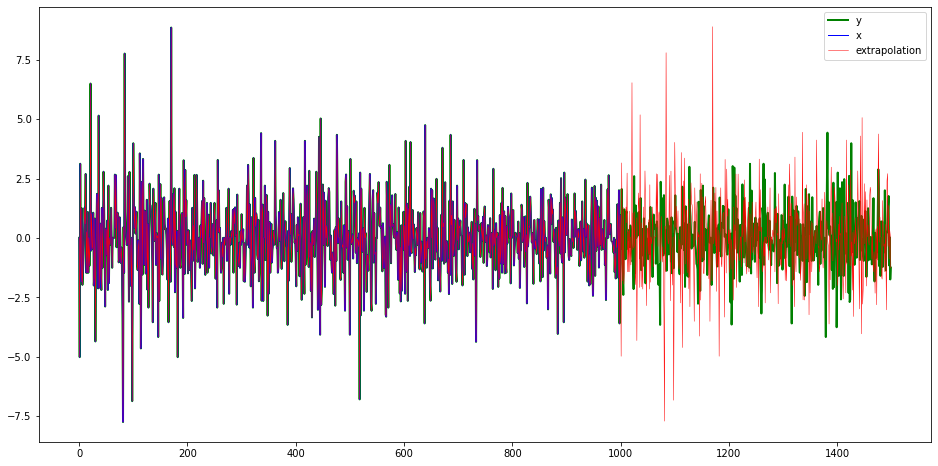

In [ ]:
n_predict = 500
x = np.array(standarized_returns)[:1000]
y = np.array(standarized_returns)[:1500]
extrapolation = fourierExtrapolation(x, n_predict)
pl.plot(np.arange(0, y.size), y, 'g', label = 'y', linewidth = 2)
pl.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 1)
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation', linewidth = 0.5)
pl.legend()
pl.show()

Transformacja Fouriera została użyta w celu znalezienia składowych harmonicznych dla naszych danych wejściowych. Liczba składowych ustalona została na 500 dla danych o rozmiarze 1000. Pozwoliło to na dosyć dobre dopasowanie szeregu Fouriera do naszych danych z giełdy. To z kolei pozwala nam na predykcję dalszych wartości stopy zwrotu, które mówią nam o zmianach. Na wykresie wyżej można zauwazyć, że o ile duże piki raczej się nie pokrywają, tak te mniejsze są dosyć dobrymi predyktorami zmian na giełdzie. Lepszy efekt możnaby uzyskać dla większej ilości danych. Tutaj do "uczenia" modelu zostało wykorzystanie tylko 1000 wartości.